<a href="https://colab.research.google.com/github/mahynski/chemometric-carpentry/blob/main/notebooks/6_Comparison_and_Inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
❓ ***Objective***: This notebook will introduce you to several ways to compare different modeling pipelines and how to inspect / understand them a bit more.  

🔁 ***Remember***: You can always revisit this notebook for reference again in the future.  Ideas and best practices will be reinforced in future notebooks, so don't worry about remembering everything the first time you see something new.

🧑 Author: Nathan A. Mahynski

📆 Date: June 17, 2024

---

We have now discussed the tools to build a modeling pipeline 🔩 including preprocessing and model selection 🤏.  We have also discussed how to use tools like GridSearchCV to optimize the hyperparameters in a pipeline.  This yields a performance estimate, and if we use [nested CV we can even get an uncertainty on this](https://pychemauth.readthedocs.io/en/latest/jupyter/learn/cv_optimization.html#Nested-CV)!

For example, we might have 3 performance estimates:

```python
pipeline_1 = [0.90, 0.97, 0.95] # 0.94 +/- 0.03
pipeline_2 = [0.85, 0.95, 0.90] # 0.90 +/- 0.04
```

🤔 But how do we know which pipelines are better than others in a statistically significant way?

# Comparing Relative Performance of Pipelines

It is tempting to perform a simple [hypothesis test](https://en.wikipedia.org/wiki/Statistical_hypothesis_test) using the mean and standard deviation of the test scores from nested CV to infer the statistical significance of any observed differences. In particular, if we always the split the data the same way (importance of specifying a random number generator seed) then we can used a [paired t-test](https://en.wikipedia.org/wiki/Paired_difference_test) to determine if there is a difference.

For example:

```python
difference = pipeline_1 - pipeline_2 = [0.05, 0.02, 0.05] # 0.04 +/- 0.01
```

⚠ However, a major assumption of these sorts of tests is the independence of the trials / measurements.  Unfortunately, because data is re-used between different folds this is not true.

⭐ How to deal with this is discussed in detail in [PyChemAuth's documentation notebook](https://pychemauth.readthedocs.io/en/latest/jupyter/learn/cv_comparison.html) on the subject.  There is also an [example notebook illustrating comparisons between authenticators](https://pychemauth.readthedocs.io/en/latest/jupyter/api/comparing_pipelines.html). (Note - some cells therein can take a while to execute)

# 👀 Model-agnostic Inspection Methods

<img src="https://christophm.github.io/interpretable-ml-book/images/big-picture.png" height=500 align="right" />

💻 AI/ML tools have demonstrated previously unparalleled capabilities in predictive computational modeling. However, to deploy these models in real-world 🌎 scenarios it is necessary to be able to explain why a model makes a prediction not just its degree of certainty, for example. This allows governments, corporations, and other users to reach a decision 🤔 about whether a model is trustworthy or not, or may exhibit a bias.

> The image at the right is from Chapter 6 of Christoph Molnar's book "Interpretable Machine Learning: A Guide for Making Black Box Models Explainable" available [here](https://christophm.github.io/interpretable-ml-book/).  It is an excellent reference.

Almost all of the best models (most accurate) are ensembles, where many individuals models are averaged; even if each individual model is interpretable/understandable to a human, their average quickly becomes opaque. Thus, interpretability methods are generally required.
* EBMs are a counterexample, and are part of an interpretable machine learning suite, [interpretML](https://interpret.ml/docs/index.html), by Microsoft Research.

👉 It is particularly important in scientific research as this can allow a researcher to inspect the "logic" behind a model's prediction to understand if the model has made a rational new discovery.

This is an enormous area of research.  [NIST](https://www.nist.gov/) is engaged in a great deal of research on safe and reliable AI:
* [AI @NIST](https://www.nist.gov/artificial-intelligence)
* [AI Standards](https://www.nist.gov/artificial-intelligence/ai-standards)
* [AI Safety Institute](https://www.nist.gov/aisi)

[NIST Interagency/Internal Report (NISTIR) - 8312](https://doi.org/10.6028/NIST.IR.8312-draft) outlines 4 principles of explainable AI:

* Explanations need to be delivered by models (they cannot be complete "black boxes", they have to give you something, somehow to evaluate the model)
* Those explanations need to be "meaningful" (subjective - depends on audience - and tricky to achieve)
* The explanations themselves need to be accurate (this is not the same as model accuracy!)
    * For example, [beware of "feature importances" in random forests](https://explained.ai/rf-importance/) - use PFI instead!
* Knowledge limits (realated to out-of-distribution detection)

Cynthia Rudin has a very nice introduction to "Explainable AI" in the YouTube video below.



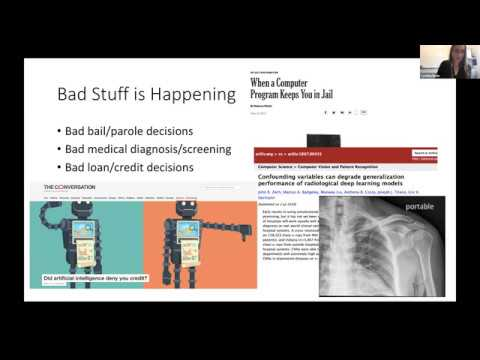

In [19]:
from IPython.display import YouTubeVideo

YouTubeVideo('I0yrJz8uc5Q', width="800", height="550")

Jay Alammar has a nice repository of [Explainable AI tools](https://ex.pegg.io/) and a cheat-sheet (below) that nicely summarizes things.

![image](https://ex.pegg.io/Explainable-AI-cheat-sheet-v0.2.1080.png)

Note that we have basically 2 avenues if we want to have an explainable system.  For this we need to define some more precise vocabulary 🗣:

1. Interpretable models - here, the model is interpretable by design.  For example, a decision tree doesn't really need a separate explanation because you can just "look" 👀 at it and understand it pretty well.

2. Explainable models - these require post-hoc explanation tools, which will be discussed below.

Post-hoc explanation tools require that the model, or pipeline, has already been fitted.  This is convenient we can perform training 🚆 and comparison ⚖, then select the pipeline we like the best and perform inspection 🔍 on it.

Model specific explanations:

---

Recall PCA.  When using this model, people often look at the loadings (coefficients on eigenvectors, possibly scaled by the square root of the eigenvalues) to understand how each feature plays a role in describing the data's "spread".

Similarly, LDA has "scalings".  In OLS, and other linear models like logistic regression, we can look at the coefficients that are built into the mathematics underlying the model itself.  

If you are committed to using a certain model, this is perfectly acceptable.  

❓ Q: But what if I need to choose between several different models?  How do we factor in, not only performance, but also how the models are "thinking" especially when different models might have different "explanation" methodologies.

🙋 A: Use a model-agnostic approach instead to compare 🍎 to 🍎.

Model agnostic approaches

---

This refers to a set of methods that essentially try to treat the entire pipeline 🔩 like a black box ⬛ that it cannot inspect directly, but instead try to infer properties based on the relationships between the input and output of the pipeline.

🗣 A "black box model" is a model that does not reveal its inner workings, i.e., it cannot be understood just by looking at its parameters (like a neural net). The opposite is sometimes called a white box ⬜ which is interpretable. Model agnostic explaination methods treat all models as black boxes so as to be indendent of their details, regardless of what color box they are in reality.

Model agnostic methods are particularly helpful when using multiple models to perform the same task and they need to be compared.

From ["Model-Agnostic Interpretability of Machine Learning" by Ribeiro et al. (2016)](https://arxiv.org/abs/1606.05386):
> "Desirable aspects of a model-agnostic explanation system are:
>
> * Model flexibility: The interpretation method can work with any machine learning model, such as random forests and deep neural networks.
> * Explanation flexibility: You are not limited to a certain form of explanation. In some cases it might be useful to have a linear formula, in other cases a graphic with feature importances.
> * Representation flexibility: The explanation system should be able to use a different feature representation as the model being explained. For a text classifier that uses abstract word embedding vectors, it might be preferable to use the presence of individual words for the explanation."


Model agnostic approaches can be divided into 2 categories:

1. 🌎 They explain global, overall behavior, or
2. 🚶 They explain individual predictions

🔬 Here we will focus on tools that are applicable to tabular data (vs. "raw data" like text or images) since this is more common in chemometric applications.  

👉 Implicit in the "world" to "data" ("capture") step from Molnar's book is the expectation that the output is "featurized" into a table.  This is not always true, but is commonly the case in scientific applications since the application of scientific principles leads to hypotheses about what exactly to collect.  This is not always correct and raw data can sometimes hide information which is one reason deep learning can sometimes be a powerful tool for science and engineering!

⭐ PyChemAuth has a complete [tutorial here](https://pychemauth.readthedocs.io/en/latest/jupyter/api/model_inspection.html), but it may be useful to read the basic overview of each technique below before working through this.

## Permutation Feature Importance (PFI)


PFI is a 🌎 global model inspection method.  sklearn has an [implementation](https://scikit-learn.org/stable/modules/permutation_importance.html) we will rely on, but the algorithm is very straightforward.

How does it work?

---

The idea is that if a feature is globally important to a model, then changing its value will strongly cause the model's prediction to change significantly, on average.

The algorithm proceeds as follows:

1. For a fitted model and tabular dataset, $X$, measure the performance (e.g., accuracy or TEFF), $s$.
2. For each feature (column in $X$), $j$, shuffle the values and recompute the performance, $s_{k,j}$.
3. Repeat this shuffling $K$ times and average the drop in performance.

The average difference defines the importance, $i_j$, of feature $j$.

$$
i_j = s - \frac{1}{k} \sum_{k=1}^K s_{k,j}
$$

👉 PFI can be computed on the training set or held-out test set; however using a held-out test set is important since you can explicitly test to compare which features are important during training vs. when applied to unseen data. Features that are important to predictions made about the training set but not the test set might indicate the model is overfit to the training set, or that the test/train split is poor.

Pros and Cons

---

* Simple and easy to understand.
* Works for any pre-trained model using tabular data which has a `score` method.  This works for regression ($R^2$ in OLS, PLS) or classification / authentication (accuracy, $TEFF$)!

However,

* It can be [highly misleading if you have multiple correlated features](https://scikit-learn.org/stable/modules/permutation_importance.html#misleading-values-on-strongly-correlated-features), so you should try to remove any multicollinear columns before training the model in question (an important preprocessing step!).  This is because when two features are correlated but only one of the features is shuffled, the model still has "access" to the latter through its correlated feature. This can make it seem like neither feature is important, when in fact they are both important!  sklearn has a nice [example](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py) of this.

---
> ❗ Read the documentation for sklearn's implementation of [PFI](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance).
---

In [20]:
from sklearn.inspection import permutation_importance
?permutation_importance

## SHapley Additive exPlanations (SHAP)

[SHAP](https://shap.readthedocs.io/en/latest/index.html) can provide both local 🚶 and global 🌎 explanations.  This is based on [Shapley values](https://en.wikipedia.org/wiki/Shapley_value), a term coined by [Lloyd Shapley](https://en.wikipedia.org/wiki/Lloyd_Shapley) in 1953 which is the [core solution to cooperative game theory](http://www.library.fa.ru/files/Roth2.pdf#page=39) - he received a Nobel Prize for this in 2012.

What does it do?

---

The creators of SHAP have an excellent [introduction and tutorial](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html) on using this to understand and explain models.

In a nutshell, this technique provides a way to break down "credit" for model output (e.g., probability of being a class member) in a fair way across all the features which contribute to this prediction.

Imagine we have a dataset with 3 features, $X$, some target, $y$, and a model that is designed to predict this as follows:

```python
X = np.array(
    [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]
    ]
)

y = [0.5, 1.0, 0.25]

model = my_pipeline.fit(X, y)

y_pred = model.predict(X)
y_pred = [0.4, 1.5, 0.5]
```

SHAP computes the average prediction over the dataset it is given (`np.mean(y_pred) = 0.8`) then breaks down the difference between this "background" and each row's prediction in a way that adds up to the difference.  For example:


```python
shap_values = np.array(
    [
        [-0.1, -0.2, -0.1],
        [0.2, 1.0, -0.5],
        [1.0, -1.0, -0.3]
    ]
)
```

Observe, how for the first row in $X$ the sum of the shap_values = -0.1 + -0.2 + -0.1 = -0.4, is the difference between the background and the model's prediction (0.8 - 0.4 = y_pred[0] = 0.4).

---
> ❗ Verify this property for all rows.
---

The SHAP value reflects how significantly each feature contributes to the model's decision making process.  For the first row, the second feature is twice as significant as features 1 and 3.

👉 Any given row provides a local 🚶 explanation of the model's prediction for that sample.  If we average the absolute value of each column across the dataset we can get a ranking of which features are the most important.  This is a 🌎 global explanation.  SHAP can do both!

```python
global_expl = np.mean(np.abs(shap_values), axis=0)

global_expl = [0.43, 0.73, 0.3]
```
According to this contrived example, feature 2 is the most significant while feature 3 is the least.

🔬 SHAP also has some incredible mathematical properties and is one of the most popular methods for interrogating models.  It can be fairly expensive and difficult to compute for large datasets, though.  But for the scale of data we typically encounter in chemometric applications we can use this just fine!

### Shapley Values

🤔 To understand these properties let's dive into some math.



### Computing SHAP Values



One way to interpret SHAP values is that they extend the idea of looking at coefficients in linear models (e.g., scalings in LDA or loadings in PCA) to non-linear cases.  First, let's look at SHAP values for a simple multilinear regression model.



In [ ]:
# Install the shap library
!pip install shap

import shap

#### Linear Models

In [57]:
import sklearn
import numpy as np

# Create some fake data that has a multilinear correlation
np.random.seed(42)
X = np.random.random((50, 5))
y = -0.3*X[:,0] - 2.0*X[:,1] + 5.1*X[:,2] # The final 2 features we will assume do not contribute

# Build a model
model = sklearn.linear_model.LinearRegression().fit(X, y)

# Explain the model
explainer = shap.explainers.Exact(model.predict, X)
shap_values = explainer(X)

In [58]:
# Observe the mean prediction ...
np.mean(model.predict(X))

1.5124612164521287

In [59]:
# ... is the "base value" for each prediction
shap_values.base_values

array([1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122,
       1.51246122, 1.51246122, 1.51246122, 1.51246122, 1.51246122])

In [84]:
# The base_value + sum(shap_values) give the predicted model output
# NOT THE TRUE Y VALUE
for ind in range(5):
    print("%.6f"%model.predict(X[ind:ind+1])[0], "%.6f"%(shap_values.base_values[ind] + np.sum(shap_values.values[ind])))

1.719378 1.719378
4.254533 4.254533
2.299462 2.299462
2.012752 2.012752
1.027394 1.027394


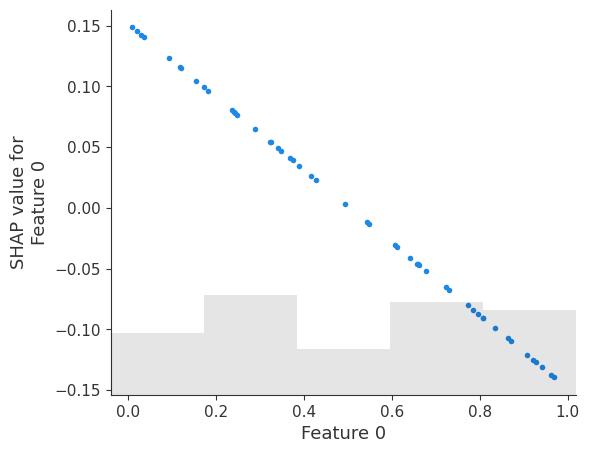

In [60]:
# Observe the slope of the line = 0.3 = feature 0 coefficient.
# In other words: shap_0 / x_0 = b_0
shap.plots.scatter(shap_values[:, 0])

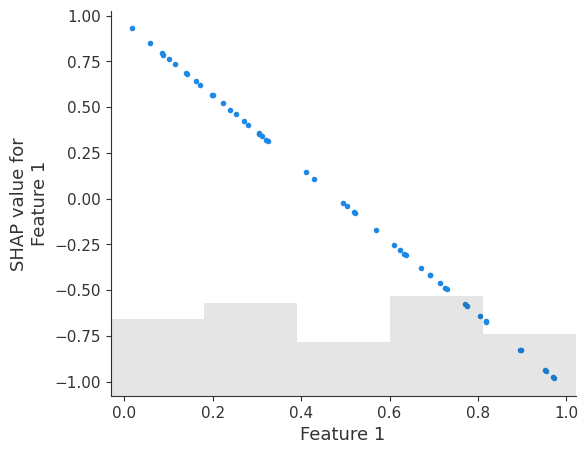

In [61]:
# Observe the slope of the line = -2.0 = feature 1 coefficient.
shap.plots.scatter(shap_values[:, 1])

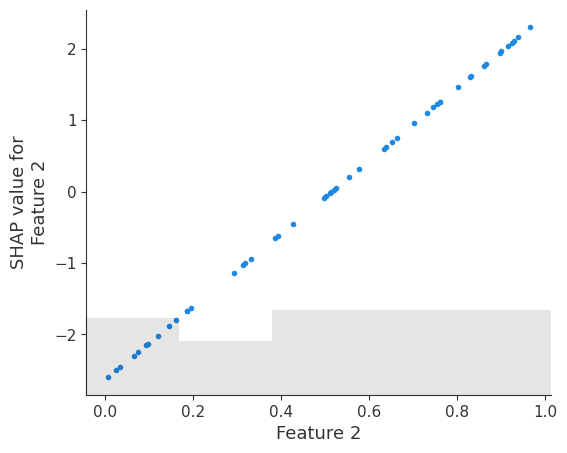

In [62]:
# Observe the slope of the line = 5.1 = feature 2 coefficient.
shap.plots.scatter(shap_values[:, 2])

[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]


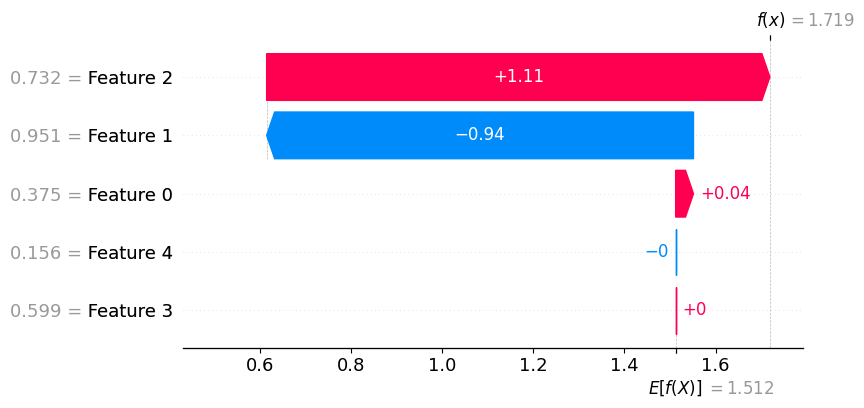

In [63]:
# Individual explanations vary because the VALUE of the features also vary
sample_ind = 0
print(X[sample_ind])
shap.plots.waterfall(shap_values[sample_ind])

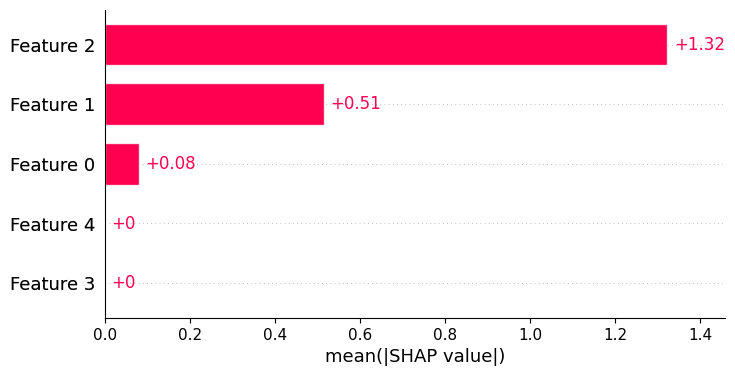

In [64]:
shap.plots.bar(shap_values)

In [73]:
# The relative significance of features is given by the ratio of (absolute) SHAP values
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)
coefs = [-0.3, -2.0, +5.1, 0.0, 0.0]

print('i \t', 'SHAP Ratio', '\t', 'Coefficient Ratio')
print('---------------------------------------------')
for i, (ave_shap_, coef_) in enumerate(zip(mean_abs_shap, coefs)):
    print(i, '\t', "%.4f"%(ave_shap_ / mean_abs_shap[0]), '\t', "%.4f"%(np.abs(coef_ / coefs[0])))

i 	 SHAP Ratio 	 Coefficient Ratio
---------------------------------------------
0 	 1.0000 	 1.0000
1 	 6.4837 	 6.6667
2 	 16.6943 	 17.0000
3 	 0.0000 	 0.0000
4 	 0.0000 	 0.0000


Features contribute the same amount (relatively) in all cases - this is not always true since non-linear models or correlations can come into play.  This example has assumec completely decorrelated features!

#### PCA

SHAP can explain the output of any model - this includes transformers!  A transformation based on PCA involves taking the dot product of the $X$ matrix with its principal eigenvectors to obtain the "scores".  The coefficients on the eigenvector(s) used are linear coefficients on the inputs so we can use SHAP to recover these as well!

1 component

2 component should be sum?

#### Logistic Regression

Now let's look at a logistic regression model

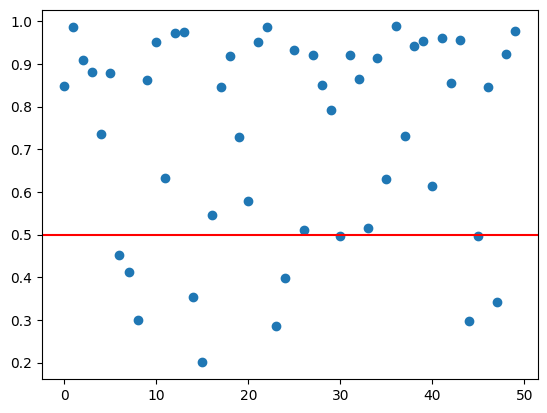

In [86]:
import matplotlib.pyplot as plt
logit_y = 1.0 / (1.0 + np.exp(-y))

plt.plot(logit_y, 'o')
plt.axhline(0.5, color='red')

#### Correlated Features and Owen Values

when there are feature correlations we can try to inlucde this - this gives Owen vaules not shap but within the scope of this course that is just semantics.

modify linear example with correlations in X for comparison


Pros and Cons

---

Best practices:
* Although [shap.Explainer](https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html#shap.Explainer) is meant to be the primary interface to the SHAP library, this selects algorithms it deems "optimal" for the parameters it was given.  While convenient, this hides details that can impede reproducibility so it is best to invoke the explainer that best fits your use case.  While there are [optimized explainers for different types of models](https://shap.readthedocs.io/en/latest/api.html), sticking to a model-agnostic one means you can stick with the same approach for all the pipeline you might train, so we generally recommend you take this approach.  Which explainer to use generally depends on the "width" of the $X$ matrix you have to deal with:
    * Use an [exact](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Exact.html) explainer when possible.  This typically works reasonably well on datasets with 10-100 features, which is fairly common in chemometric applications; e.g., if dealing with stable isotope and trace element data.
    * Sometimes there are more features than this; e.g., when dealing with spectral data (mass, NMR, etc.).  In this case, it is recommended to use a [permutation](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Permutation.html) explainer instead.  Although approximate, it still has the properties that attributions "add up" correctly.

# Do I Need More Data?